In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import sys
import os
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybel
from rdkit.Chem import AllChem, DataStructs, SDMolSupplier, Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML
from PIL import Image
import base64

from io import BytesIO

In [94]:
dir_temp = "DB3"
des = "morg"
try:
    print("done processing dataframe")
    str_temp = "../data/desc/" + dir_temp + "/desc_calc_" + dir_temp + "_" + des + ".pkl"
    print(str_temp)
    df = pd.read_pickle(str_temp)
    pkl = 1
except:
    print("done processing dataframe")
    str_temp = "../data/desc/" + dir_temp + "/desc_calc_" + dir_temp + "_" + des + ".h5"
    print(str_temp)
    df = pd.read_hdf(str_temp)
    pkl = 0

print(len(df))
print(df.head())
HOMO = df["HOMO"].to_numpy()
HOMO_1 = df["HOMO-1"].to_numpy()
diff = df["diff"].to_numpy()

scale_diff = (np.max(diff) - np.min(diff))
diff = (diff - np.min(diff)) / scale_diff




done processing dataframe
../data/desc/DB3/desc_calc_DB3_morg.pkl
58186
                     name                                                mat  \
0               BQ_BQ.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   bis-23_Br_C(=O)OC.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
2  bis-23_Br_C(C)(C)C.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  bis-23_Br_C(F)(F)F.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4         bis-23_Br_C.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   

       HOMO   HOMO-1      diff  
0 -0.178137 -0.10442 -0.073717  
1 -0.194477 -0.12122 -0.073257  
2 -0.183278 -0.11228 -0.070998  
3 -0.194816 -0.12312 -0.071696  
4 -0.186318 -0.11101 -0.075308  


In [95]:

def xgboost(x_train, x_test, y_train, y_test, scale, dict=None):

    params = {
        "colsample_bytree": 0.5,
        "learning_rate": 0.1,
        "max_depth": 10, "gamma": 0.00,
        "lambda": 0.0,
        "alpha": 0,
        "eta": 0.01,
        "n_estimators": 2000}

    reg = xgb.XGBRegressor(**params, objective="reg:squarederror", tree_method="gpu_hist")

    params = {"max_depth":40,
              "n_estimators": 5000,
              "min_samples_split": 3,
              "n_jobs": 16,
              "verbose": False
              }
    reg = RandomForestRegressor(**params)

    t1 = time.time()
    # non grid
    print(y_train)
    reg.fit(x_train, y_train)
    t2 = time.time()

    time_el = t2 - t1
    score = reg.score(x_test, y_test)
    print("xgboost score:               " + str(score) + " time: " + str(time_el))
    score = str(mean_squared_error(reg.predict(x_test), y_test))
    print("MSE score:   " + str(score))
    score = str(mean_absolute_error(reg.predict(x_test), y_test))
    print("MAE score:   " + str(score))
    score = str(r2_score(reg.predict(x_test), y_test))
    print("r2 score:   " + str(score))
    score = str(r2_score(reg.predict(x_train), y_train))
    print("r2 score:   " + str(score))
    score_mae = mean_absolute_error(reg.predict(x_test), y_test)
    print("scaled MAE")
    print(scale * score_mae)
    return reg

def morgan(dir, bit_length=1024):
    morgan = []
    names = []
    ret_arr = []
    bitInfo_arr = []
    mol_arr = []
    count = 0 
    dir = "../data/sdf/master.sdf"
    mols = [ i for i in SDMolSupplier(dir)]

    for i, suppl in enumerate(mols):
        #bitInfo = {}
        #fp = AllChem.GetMorganFingerprintAsBitVect(suppl, 2, bitInfo=bitInfo,nBits=int(bit_length))

        try:
            bitInfo = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(suppl, 2, bitInfo=bitInfo,nBits=int(bit_length))
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            names.append(suppl.GetProp("NAME"))
            ret_arr.append(arr)
            morgan.append(fp)
            bitInfo_arr.append(bitInfo)
            count += 1 
            #print(count)
            sys.stdout.write(count)
            sys.stdout.write("\r %s / " % i + str(len(mols)))
            sys.stdout.flush()
        except:
            pass

    morgan = np.array(morgan)
    print("successfully processed " + str(count) + " out of " + str(len(mols)) + " molecules")
    return names, morgan, ret_arr, bitInfo_arr, mols

In [5]:
names, morganArr, retArr, bitInfoArr, molArr = morgan(dir = dir,bit_length = 1024)
print("input begun with processing dataframe")

RDKit ERROR: [07:46:51] ERROR: Cannot convert tet to int on line 636850
RDKit ERROR: [07:46:51] ERROR: moving to the begining of the next molecule
RDKit ERROR: [07:46:51] ERROR: Cannot convert tet to int on line 775355
RDKit ERROR: [07:46:51] ERROR: moving to the begining of the next molecule
RDKit ERROR: [07:46:52] ERROR: Cannot convert tet to int on line 1274313
RDKit ERROR: [07:46:52] ERROR: moving to the begining of the next molecule
RDKit ERROR: [07:46:55] ERROR: Cannot convert tet to int on line 2986516
RDKit ERROR: [07:46:55] ERROR: moving to the begining of the next molecule
RDKit ERROR: [07:46:56] ERROR: Cannot convert tet to int on line 3205242
RDKit WARNING: [07:46:57] WARNING: not removing hydrogen atom without neighbors


successfully processed 61487 out of 61492 molecules
input begun with processing dataframe


In [7]:
mat = list(df["mat"])
mat = preprocessing.scale(np.array(mat))
scale = np.max(np.array(df["HOMO"])) - np.min(np.array(df["HOMO"]))


/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [9]:
x = np.array(mat)
y = np.array(np.array(df["HOMO"]))
indices = range(len(x))
try:
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)
except:
    x = list(x)
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)

reg = xgboost(x_train, x_test, y_train, y_test, scale)


[-0.201119 -0.21547 -0.18903 ... -0.202038 -0.182855 -0.195778]
xgboost score:               0.7895405775228911 time: 377.34160351753235
MSE score:   3.4182453702874294e-05
MAE score:   0.003599017165961432
r2 score:   0.7378024529372622
r2 score:   0.9605562082293522
scaled MAE
0.0004367803222782454


In [10]:
fimportance = reg.feature_importances_
fimportance_dict = dict(zip(range(1024), fimportance))
sorteddata = sorted(fimportance_dict.items(), key=lambda x: -x[1])
top25feat = [x[0] for x in sorteddata][:25]
top50feat = [x[0] for x in sorteddata][:50]


In [42]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print([i for i in take(25,sorteddata)])


[(203, 0.17041502238302703), (139, 0.11604384871467595), (112, 0.09283654970612464), (59, 0.06059186300930724), (186, 0.04336839151248946), (7, 0.037724418858353634), (162, 0.029247777738404635), (164, 0.016446294064835883), (210, 0.011797823630647896), (241, 0.011682845291261283), (174, 0.009862841922917216), (249, 0.009569828938454384), (39, 0.009347691063790148), (50, 0.008008320828987019), (150, 0.007883286602882572), (72, 0.00768782846053874), (204, 0.007560962945979851), (38, 0.007531716930873843), (224, 0.006406432178756455), (46, 0.006089401770472929), (109, 0.0059798745301557045), (30, 0.005519509406042386), (78, 0.005466276606046378), (166, 0.005121986602243287), (67, 0.004651522183398108)]


In [12]:
print(top25feat)

[203, 139, 112, 59, 186, 7, 162, 164, 210, 241, 174, 249, 39, 50, 150, 72, 204, 38, 224, 46, 109, 30, 78, 166, 67]


In [43]:
print(top10feat)

[203, 139, 112, 59, 186, 7, 162, 164, 210, 241]


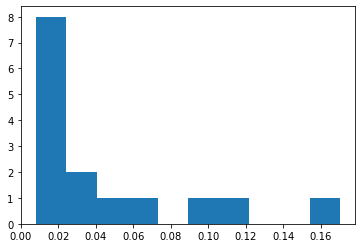

[203, 139, 112, 59, 186, 7, 162, 164, 210, 241]


In [47]:
top50feat = [x[0] for x in sorteddata][:50]
top10feat = [x[0] for x in sorteddata][:10]

plt.hist([i[1] for i in take(15,sorteddata)])
plt.show()
print(top10feat)

[203, 139, 112, 59, 186, 7, 162, 164, 210, 241, 174, 249, 39, 50, 150, 72, 204, 38, 224, 46, 109, 30, 78, 166, 67]
[0.17041502238302703, 0.11604384871467595, 0.09283654970612464, 0.06059186300930724, 0.04336839151248946, 0.037724418858353634, 0.029247777738404635, 0.016446294064835883, 0.011797823630647896, 0.011682845291261283]


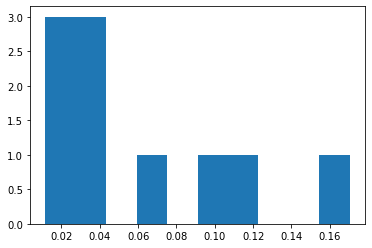

In [105]:
print(top25feat)
print([sorteddata[i][1] for i in range(10)])
plt.hist([sorteddata[i][1] for i in range(10)])
plt.show()


In [16]:
print(top25feat)

[203, 139, 112, 59, 186, 7, 162, 164, 210, 241, 174, 249, 39, 50, 150, 72, 204, 38, 224, 46, 109, 30, 78, 166, 67]


In [17]:
testidx = np.argsort(y_test)
print(sorted(y_test))
print(testidx)
print(len(testidx))
slice_conv = tuple(slice(x) for x in testidx)

[-0.23965, -0.238905, -0.237889, -0.236209, -0.234323, -0.233699, -0.233533, -0.233471, -0.233456, -0.233222, -0.23254, -0.232316, -0.232033, -0.232001, -0.231871, -0.231853, -0.231609, -0.231579, -0.231101, -0.230955, -0.230694, -0.229601, -0.229297, -0.229244, -0.229229, -0.229222, -0.229075, -0.228968, -0.228636, -0.228627, -0.228602, -0.228428, -0.228292, -0.228258, -0.228223, -0.228166, -0.22812, -0.228109, -0.228105, -0.227885, -0.227825, -0.227791, -0.227777, -0.227677, -0.227569, -0.227551, -0.227414, -0.227389, -0.227371, -0.227363, -0.227312, -0.22729, -0.227272, -0.227266, -0.227258, -0.227199, -0.227095, -0.227003, -0.226976, -0.226947, -0.226866, -0.226846, -0.226752, -0.22671, -0.226507, -0.226498, -0.226361, -0.226325, -0.226273, -0.226265, -0.226162, -0.226157, -0.226089, -0.226076, -0.225842, -0.225771, -0.225748, -0.225689, -0.225646, -0.225597, -0.225583, -0.225547, -0.225526, -0.225485, -0.225477, -0.225393, -0.225345, -0.225344, -0.225313, -0.225251, -0.225236, -0.

In [18]:
#slice_conv = tuple(slice(x) for x in testidx)
#print(x_test[testidx][0:4])
#print(reg.predict(x_test[testidx][0].reshape(1,-1)))
#print(reg.predict(x_test[testidx][0:4]))
#print(y_test[0:4])
#print(onbit)
#print(set(onbit))
#print(set(top50feat))
#print(set(onbit) & set(top50feat))

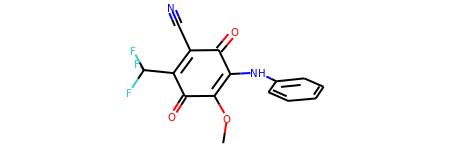

In [33]:
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
testmols = [molArr[i] for i in testidx]
testmols[0]

In [102]:
pd.set_option('display.max_colwidth', -1)


def get_thumbnail(path):
    path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html(formatters={'Image': image_formatter}, escape=False) + css).replace("\n",'\\') + '\';'
    s += '</script>'

    return(HTML(s+css))

/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.



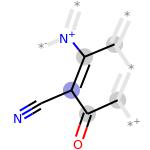
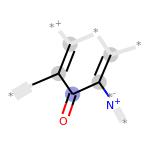
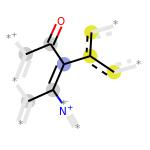
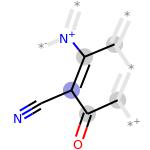
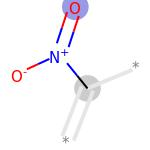
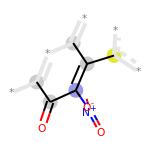
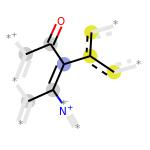
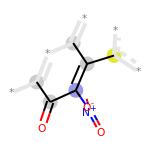
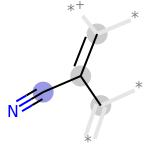
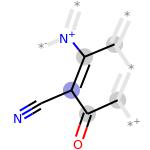
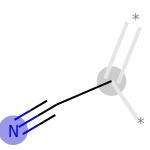
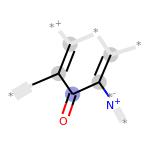
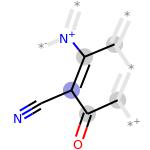
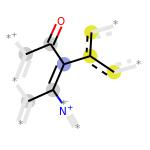
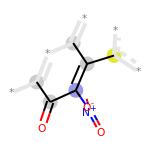
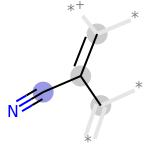
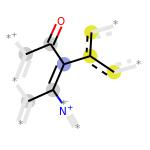
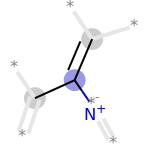
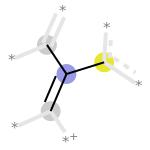
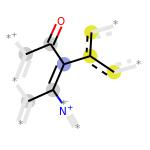
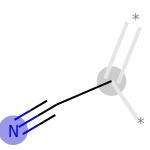
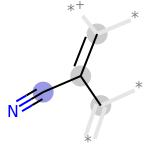
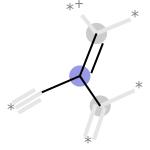
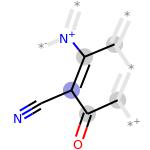
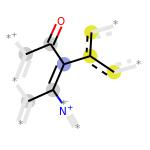
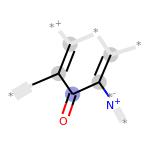
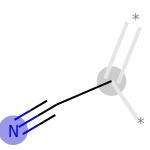
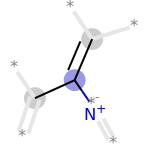
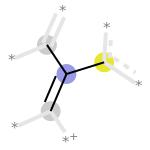
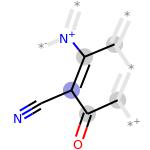
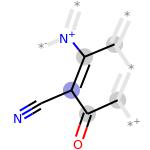
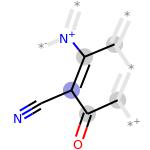
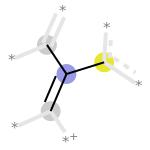
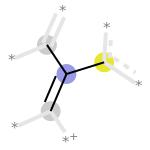
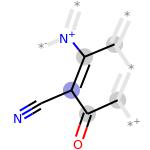
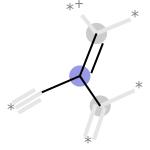
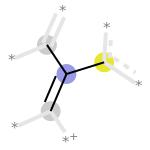
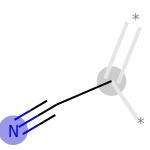
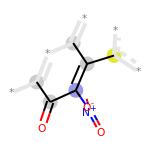
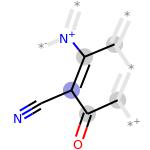
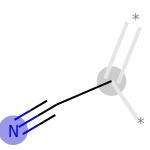
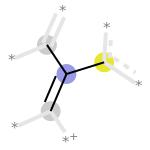
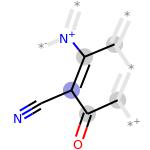
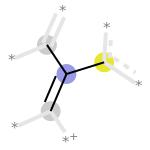
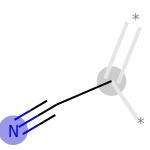
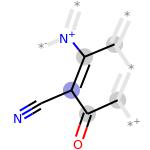
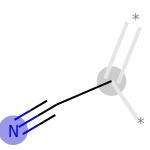
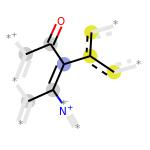
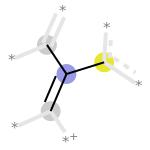
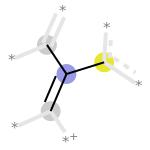
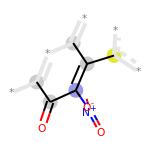
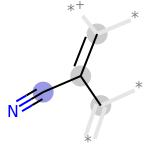
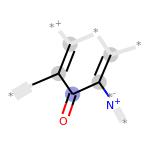
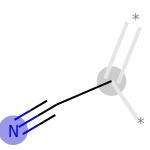
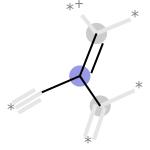
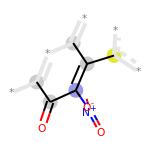
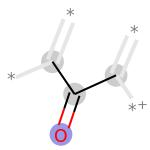
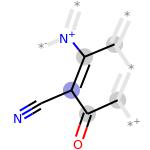
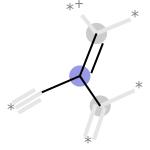
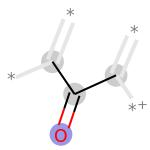
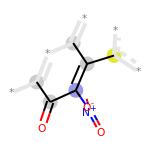
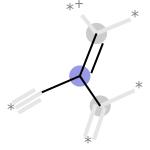
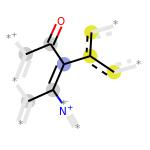
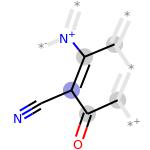
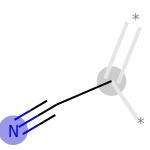
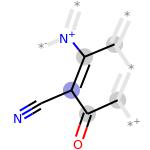
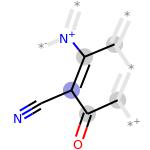
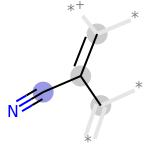
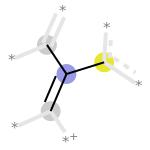
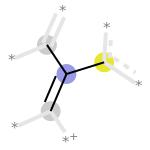
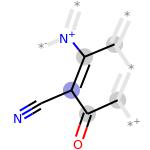
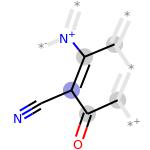
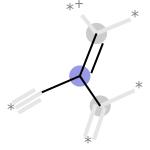
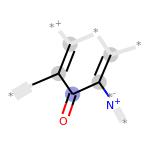
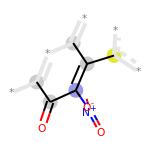
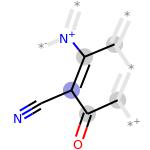
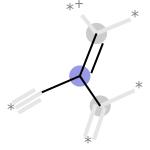
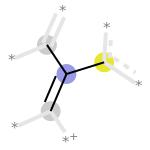
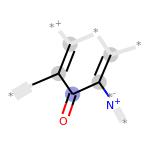
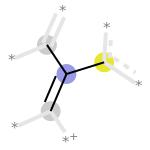
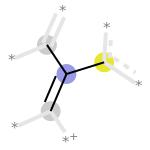
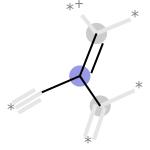
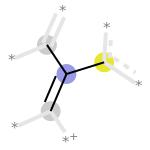
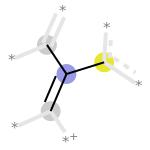
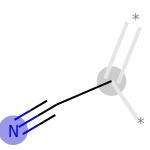
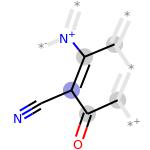
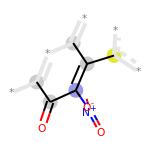
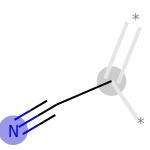
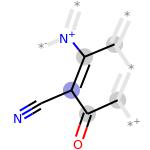
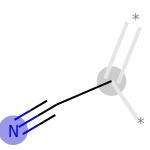
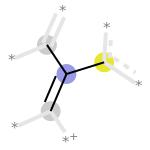
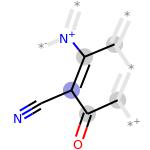
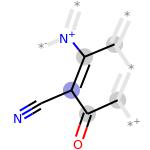
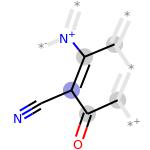
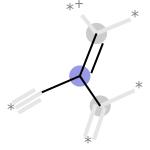
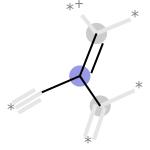
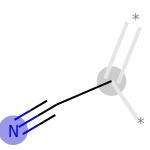
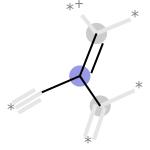
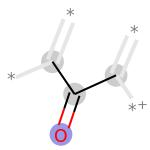
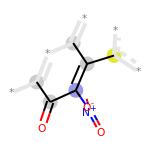
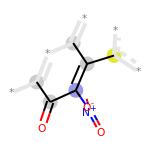
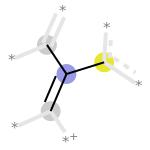
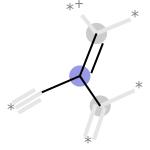
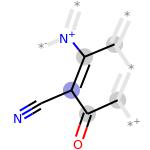
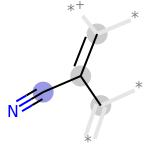
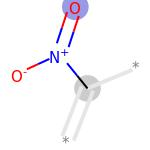
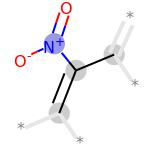
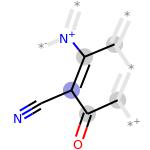
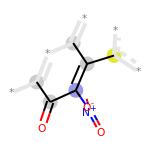
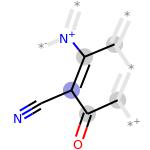
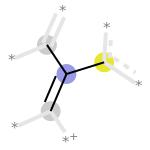
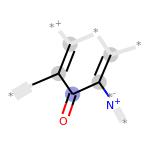
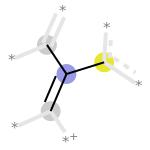
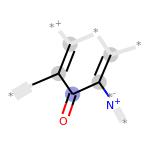
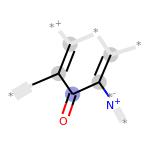
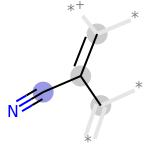
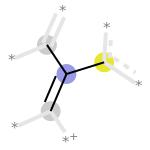
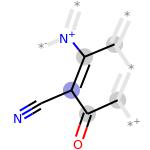
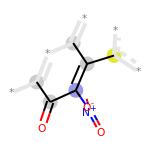
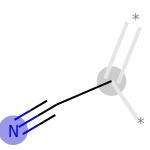
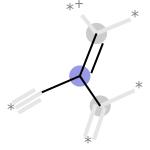
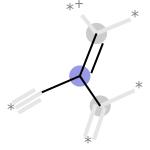
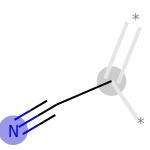
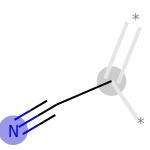
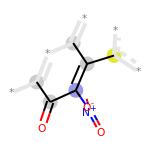
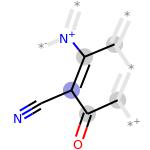
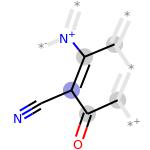
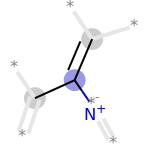
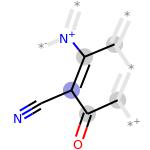
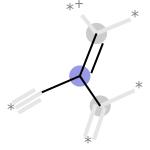
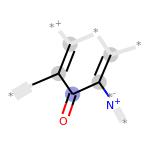
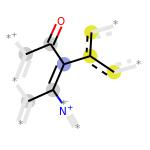
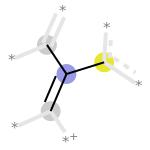
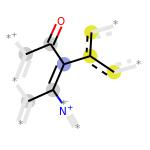
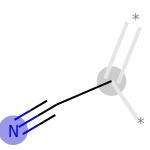
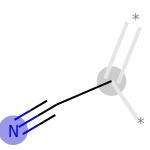
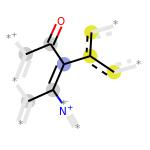
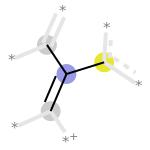
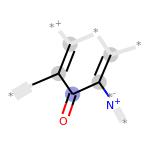
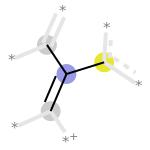

In [107]:
#output for single molecule
tpls = []

for i in range(len(testmols)):
    try:
        #print([i for i in testidx])
        bitInfo={}
        fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        onbit = [bit for bit in bitInfo.keys()]
        #print(onbit)
        #print(top10feat)
        importantonbits = list(set(onbit) & set(top10feat))
        #print(importantonbits)
        #append to this array 
        if (importantonbits != []):
            tpls.append([(testmols[test_probe], x, bitInfo) for x in importantonbits])
        #print(tpls[1][2])
        no_repeat = {}
    except:
        pass
          
#print(tpls)
rows = []
for frag in tpls: 
    #img.append(getSubstructDepiction(frag[0][0],frag[0][1],frag[0][2],molSize=(450,200)))
    fp = frag[0][1]
    img = Draw.DrawMorganBit(frag[0][0], frag[0][1], frag[0][2])
    #img.append(Draw.DrawMorganBits(frag))
    rows.append([fp, img])
df = pd.DataFrame(rows, columns=("FP", "Image"))
#HTML(df.to_html(formatters={'Image': image_formatter}, escape=False))

View(df)


In [ ]:
test_probe = 5
tpls_full = []

#print([i for i in testidx])

for i in range(len(testmols)):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    importantonbits = list(set(onbit) & set(top10feat))
    #append to this array 
    tpls.extend([(testmols[i], x, bitInfo) for x in importantonbits])

no_repeat = []
key_log = []

for i in range(len(testmols)):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    
    onbit = [bit for bit in bitInfo.keys()]
    temp_onbit = []
    temp_bitinfo = {}
    
    #filters for unique keys in array
    for keys in onbit:    
        if keys in key_log:
            pass
        else:
            temp_onbit.append(keys)
            key_log.append(keys)
            
    importantonbits = list(set(temp_onbit) & set(top25feat)) 
    
    #appends only new bitinfo arrays
    for i in importantonbits:
        temp_bitinfo[i] = bitInfo[i] 

    if (len(importantonbits) != 0): 
        print(len(importantonbits))
        print(len(temp_bitinfo))
        #print(importantonbits)
        #print(x)
        #print(bitInfo)
    
        no_repeat.extend([(testmols[i], x, temp_bitinfo) for x in importantonbits])

Draw.DrawMorganBits(tpls)


In [ ]:
tpls_full = []

#print([i for i in testidx])


for i in range(len(testmols)-800):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    importantonbits = list(set(onbit) & set(top10feat))
    importantonbits = list(set(onbit) & set([top10feat[10]]))
    #append to this array 
    if(len(importantonbits) > 0 ):
        tpls_full.extend([(testmols[i], x, bitInfo) for x in importantonbits])

no_repeat = []
key_log = []
Draw.DrawMorganBits(tpls_full)


In [ ]:
print(len(no_repeat))
print(len(tpls))
print(no_repeat)
#Draw.DrawMorganBits(no_repeat)

In [ ]:
top_feat = [x[:, i] for i in top10feat]
print(len(x[:,1]))
import pandas as pd 
df = pd.DataFrame(top_feat)
df = df.transpose()
df["HOMO"] = y
df.corr()
#print(np.shape(y))
#print(np.shape(np.delete(y, [267])))
#print(np.delete(np.delete(y, [6990]), [267]))
#df["HOMO"] = np.delete(y, [267])

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
corr = np.array(df.corr()["HOMO"].to_numpy())[0:-1]
ax = plt.subplot(1,1,1)

plt.title("Correlation Top Fingerprints vs. HOMO")
ax.bar(range(10), corr)
print([str(i) for i in top10feat])
ax.set_xticklabels([str(i) for i in top10feat], rotation="45")
ax.set_xticks(np.arange(len(top10feat)))
plt.show()